In [10]:
import feedparser
from newspaper import Article
from transformers import pipeline
from collections import Counter
from dateutil import parser
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/surjunk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0



📰 Reuters:
----------------------------------------

📰 Yahoo Finance:
----------------------------------------

Title: Heavily shorted AI stock is rapidly climbing the Fortune 500
Date: 2025-06-03 22:07:00
Link: https://finance.yahoo.com/news/heavily-shorted-ai-stock-rapidly-220700634.html
Sentiment: POSITIVE (Confidence: 0.667)

Title: Wells Fargo escapes Fed's asset cap after seven years, able to pursue growth
Date: 2025-06-03 20:26:16
Link: https://finance.yahoo.com/news/fed-removes-wells-fargos-asset-202616156.html
Sentiment: POSITIVE (Confidence: 1.0)

Title: Fed lifts restrictions placed on Wells Fargo in 2018 because of its fake-accounts scandal
Date: 2025-06-03 20:57:37
Link: https://finance.yahoo.com/news/fed-lifts-restrictions-placed-wells-205737847.html
Sentiment: NEGATIVE (Confidence: 0.667)

Title: These Stocks Moved the Most Today: Nvidia, Tesla, Dollar General, Credo, Ferguson, Moonlake, and More
Date: 2025-06-03 20:25:00
Link: https://www.barrons.com/articles/stock-mov

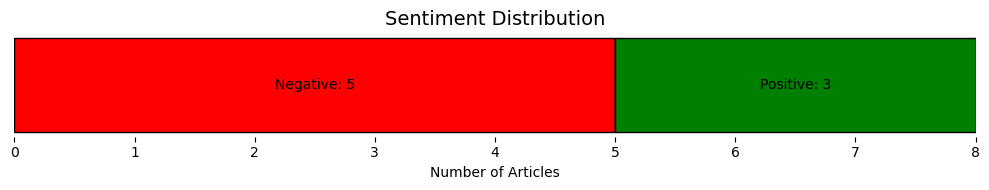

In [12]:
# Load Sentiment Model:  (cardiffnlp/twitter-roberta-base-sentiment-latest)
sentiment_model = pipeline("sentiment-analysis")

# === RSS Feeds (Top Financial News Sources) ===
rss_feeds = {
    "Reuters": "https://feeds.reuters.com/reuters/businessNews",
    "Yahoo Finance": "https://finance.yahoo.com/news/rssindex",
    "MarketWatch": "https://feeds.marketwatch.com/marketwatch/topstories/",
    "CNBC": "https://www.cnbc.com/id/100003114/device/rss/rss.html"
}

# === Fetch Latest News Entries ===
def fetch_articles(feed_url, limit=5):
    feed = feedparser.parse(feed_url)
    return feed.entries[:limit]

# === Extract Full Article Text ===
def extract_article_text(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        return article.text
    except:
        return ""

# === Analyze Sentiment Over Entire Article (chunked) ===
def analyze_full_article(text):
    chunk_size = 1024
    sentiments = []

    for i in range(0, len(text), chunk_size):
        chunk = text[i:i+chunk_size]
        if len(chunk.strip()) < 20:
            continue  # Skip short junk

        result = sentiment_model(chunk)[0]
        sentiments.append(result['label'].upper())

    if not sentiments:
        return "NEUTRAL", 0

    counts = Counter(sentiments)
    label = counts.most_common(1)[0][0]
    confidence = round(counts[label] / len(sentiments), 3)  # e.g. 0.75
    return label, confidence

# === Plot Horizontal Stacked Bar ===
def plot_horizontal_sentiment_bar(sentiment_counts):
    negative = sentiment_counts.get("NEGATIVE", 0)
    neutral = sentiment_counts.get("NEUTRAL", 0)
    positive = sentiment_counts.get("POSITIVE", 0)

    total = negative + neutral + positive
    if total == 0:
        print("No sentiment data to plot.")
        return

    colors = ['red', 'lightgray', 'green']
    labels = ['Negative', 'Neutral', 'Positive']
    values = [negative, neutral, positive]

    fig, ax = plt.subplots(figsize=(10, 2))
    left = 0

    for value, color, label in zip(values, colors, labels):
        ax.barh(y=0, width=value, left=left, color=color, edgecolor='black')
        if value > 0:
            ax.text(left + value / 2, 0, f"{label}: {value}", ha='center', va='center', fontsize=10)
        left += value

    ax.set_xlim(0, total)
    ax.set_yticks([])
    ax.set_title("Sentiment Distribution", fontsize=14)
    ax.set_xlabel("Number of Articles")
    plt.box(False)
    plt.tight_layout()
    plt.show()

# === Main Routine ===
def main():
    total_counts = {"POSITIVE": 0, "NEGATIVE": 0, "NEUTRAL": 0}

    for source, url in rss_feeds.items():
        print(f"\n📰 {source}:\n" + "-"*40)
        entries = fetch_articles(url)

        for entry in entries:
            title = entry.title
            link = entry.link

            pub_date_raw = entry.get('published', entry.get('updated', 'No date provided'))
            try:
                pub_date = parser.parse(pub_date_raw).strftime("%Y-%m-%d %H:%M:%S")
            except Exception:
                pub_date = pub_date_raw

            print(f"\nTitle: {title}")
            print(f"Date: {pub_date}")
            print(f"Link: {link}")

            text = extract_article_text(link)
            if not text:
                print("⚠️ Could not extract full article. Skipping.")
                continue

            label, confidence = analyze_full_article(text)
            print(f"Sentiment: {label} (Confidence: {confidence})")
            total_counts[label] += 1

    # === Summary ===
    print("\n\n📊 Sentiment Summary Across All Sources:")
    total = sum(total_counts.values())
    for label, count in total_counts.items():
        pct = (count / total) * 100 if total else 0
        print(f"{label}: {count} articles ({int(pct)}%)")

    # Plot bar chart of sentiments
    plot_horizontal_sentiment_bar(total_counts)

if __name__ == "__main__":
    main()

